### Question 1

To be able to understand how data is loaded on QS World University Ranking, we've started by using Postman with Postman Interceptor. We were able to find that the following *txt* file containing the ranking was loaded with the page:

`https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1507993707650`

Based on this file, we start by parsing the file and browsing the content:

In [51]:
%matplotlib inline

import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np

In [52]:
response = requests.get('https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1507993707650')
raw_universities = response.json()['data'][:200]

Data is stored in json format, and is already clean. We can directly store it in the dataframe. We need also to grab additional data to get the number of students.

In [53]:
def get_number(soup, selector):
    selected = soup.select(selector)
    
    if (len(selected) == 0): # If no information is given for the current university
        return np.nan
    
    raw_number = selected[0].text
    
    return int(re.sub('[\,\ ,\\n]', '', raw_number))

def get_people(path):
    response = requests.get('https://www.topuniversities.com' + path)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    people = {}
    people['faculty'] = {}
    people['student'] = {}
    
    people['faculty']['total'] = get_number(soup, 'div.total.faculty div.number')
    people['faculty']['inter'] = get_number(soup, 'div.inter.faculty div.number')
    people['student']['total'] = get_number(soup, 'div.total.student div.number')
    people['student']['inter'] = get_number(soup, 'div.total.inter div.number')
               
    return people


universities_top = pd.DataFrame()

for university in raw_universities:
    people = get_people(university['url'])
    
    row = pd.DataFrame({
        'Name': [university['title']],
        'Rank': [int(university['rank_display'].strip('='))],
        'Country': [university['country']],
        'Region': [university['region']],
        'Total Students': [people['student']['total']],
        'International Students': [people['student']['inter']],
        'Total Faculty Members': [people['faculty']['total']],
        'International Faculty Members': [people['faculty']['inter']],
    })
    
    universities_top = universities_top.append(row)
    
universities_top = universities_top.set_index(['Name'])

assert universities_top.index.is_unique, 'Index should be unique'
assert universities_top.Rank.count() == 200, 'DataFrame should contain the top 200 universities'

universities_top.head()

,Country,International Faculty Members,International Students,Rank,Region,Total Faculty Members,Total Students
Name,,,,,,,
Massachusetts Institute of Technology (MIT),United States,1679.0,3717.0,1,North America,2982.0,11067.0
Stanford University,United States,2042.0,3611.0,2,North America,4285.0,15878.0
Harvard University,United States,1311.0,5266.0,3,North America,4350.0,22429.0
California Institute of Technology (Caltech),United States,350.0,647.0,4,North America,953.0,2255.0
University of Cambridge,United Kingdom,2278.0,6699.0,5,Europe,5490.0,18770.0


In [54]:
# We search for missing data

universities_top[universities_top.isnull().any(axis=1)]

,Country,International Faculty Members,International Students,Rank,Region,Total Faculty Members,Total Students
Name,,,,,,,
New York University (NYU),United States,NaN,NaN,52,North America,NaN,NaN
Indian Institute of Science (IISc) Bangalore,India,NaN,47.0,190,Asia,423.0,4071.0


As we can see here, there is no data at all for New York University and no data for international faculty members in IISc. By checking the page of the later one (https://www.topuniversities.com/universities/indian-institute-science-iisc-bangalore#wurs) we can see that the university is more likely to have no international faculty members. We can replace the NaN with 0 safely.

For NYU, data should be missing (as we can't have an university with no faculty members and no students). We keep the line so we may be able to complete it during the merge of the two dataframes in question 3.

In [55]:
# Cleaning the data

universities_top.set_value('Indian Institute of Science (IISc) Bangalore', 'International Faculty Members', 0)

# Simple assertions to check for incoherency

assert universities_top.loc[universities_top['Total Faculty Members'] == 0].Rank.count() == 0, 'There should be at least 1 faculty member'
assert universities_top.loc[universities_top['Total Students'] == 0].Rank.count() == 0, 'There should be at least 1 faculty student'

Data is properly imported and clean. We can now start do the asked computations. Data in the dataframe is sufficient to perform the computations directly. We divide the concerned columns, sort the result and cut the 10 first results.

In [56]:
def best_faculty_ratio(universities):
    return (universities['Total Faculty Members'] / universities['Total Students']).sort_values(ascending=False)[:10]

def best_international_ratio(universities):
    return (universities['International Students'] / universities['Total Students']).sort_values(ascending=False)[:10]

In [57]:
faculty_ratio = best_faculty_ratio(universities_top)
faculty_ratio

Name
California Institute of Technology (Caltech)    0.422616
Yale University                                 0.398323
University of Oxford                            0.342292
University of Cambridge                         0.292488
Johns Hopkins University                        0.276353
Stanford University                             0.269870
Massachusetts Institute of Technology (MIT)     0.269450
University of Rochester                         0.266604
University of Pennsylvania                      0.266437
Columbia University                             0.247115
dtype: float64

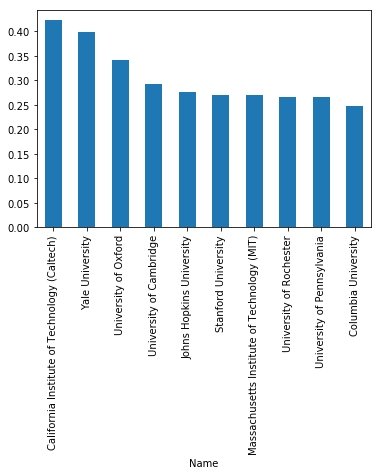

In [58]:
faculty_ratio.plot(kind='bar')

In [59]:
international_ratio_top = best_international_ratio(universities_top)
international_ratio_top

Name
London School of Economics and Political Science (LSE)    0.691393
Ecole Polytechnique Fédérale de Lausanne (EPFL)           0.570047
Imperial College London                                   0.543567
Maastricht University                                     0.502533
Carnegie Mellon University                                0.478062
UCL (University College London)                           0.477928
University of St Andrews                                  0.457955
The University of Melbourne                               0.427434
Queen Mary University of London                           0.421816
The University of Hong Kong                               0.407144
dtype: float64

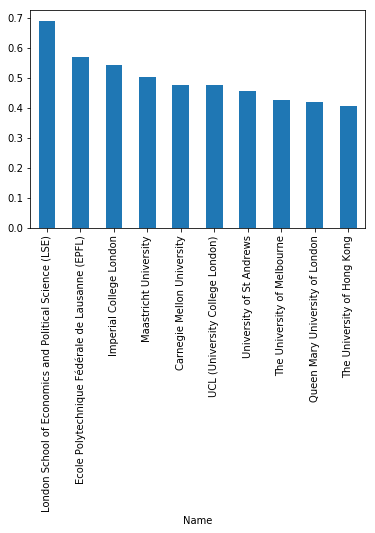

In [60]:
international_ratio_top.plot(kind='bar')

We use the `groupby` function to aggregate data per country and then per region.

In [61]:
by_country = universities_top.groupby(['Country']).sum()

print(best_faculty_ratio(by_country))
print(best_international_ratio(by_country))

Country
Russia            0.221910
Denmark           0.177261
Saudi Arabia      0.175828
Singapore         0.161530
Malaysia          0.153893
Japan             0.152479
South Korea       0.141721
Switzerland       0.140434
United Kingdom    0.136962
Israel            0.136047
dtype: float64
Country
Australia         0.352189
United Kingdom    0.341705
Hong Kong         0.310751
Austria           0.309980
Switzerland       0.302396
Singapore         0.276537
Canada            0.260161
New Zealand       0.258215
Ireland           0.235299
Netherlands       0.232980
dtype: float64


In [62]:
by_region = universities_top.groupby(['Region']).sum()

faculty_by_region = best_faculty_ratio(by_region)
international_by_region = best_international_ratio(by_region)

print(faculty_by_region)
print(international_by_region)

Region
Asia             0.132260
North America    0.117776
Europe           0.111564
Latin America    0.104147
Africa           0.088450
Oceania          0.072385
dtype: float64
Region
Oceania          0.339261
Europe           0.229589
North America    0.188906
Africa           0.169703
Asia             0.136431
Latin America    0.084615
dtype: float64


Plotting some of the results allows to understand data disparity:

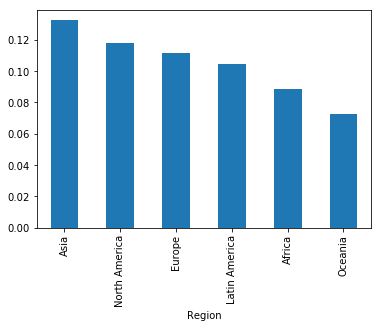

In [63]:
# Proportion of faculty members compared to the number of students per region

faculty_by_region.plot(kind='bar')

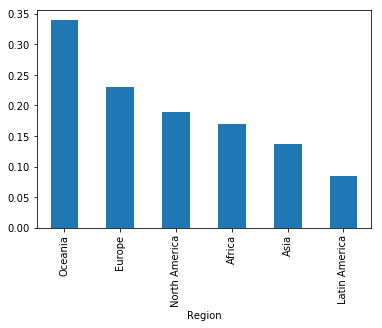

In [64]:
# We can see that Oceania international student ratio is significantly higher.
# This can be explained by the low representativity of Oceania in total's world population.
# https://en.wikipedia.org/wiki/List_of_continents_by_population

international_by_region.plot(kind='bar')

### Question 2

Using the same method as in the first question, we found that data was loaded from the following json file:

`https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json`

We will use information about proportion of international students and faculty members to retreive the values.

In [65]:
response = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')
raw_universities = response.json()['data'][:200]

In [66]:
def percentageToFloat(x):
    return float(x.strip('%'))/100

In [67]:
universities_times = pd.DataFrame()

for university in raw_universities:
    total_students = university['stats_number_students'].replace(',', '')
    row = pd.DataFrame({
        'Name': [university['aliases']],
        'Rank': [int(university['rank'].strip('='))],
        'Country': [university['location']],
        'Region': '',
        'Total Students': [int(total_students)],
        'International Students': [int(percentageToFloat(university['stats_pc_intl_students']) * float(total_students))],
        'Total Faculty Members': [int(float(total_students) / float(university['stats_student_staff_ratio']))],
    })
    
    universities_times = universities_times.append(row)
    
universities_times = universities_times.set_index(['Name'])

assert universities_times.index.is_unique, 'Index should be unique'
assert universities_times.Rank.count() == 200, 'DataFrame should contain the top 200 universities'

In [68]:
universities_times.head()

,Country,International Students,Rank,Region,Total Faculty Members,Total Students
Name,,,,,,
University of Oxford,United Kingdom,7755,1,,1822,20409
University of Cambridge,United Kingdom,6436,2,,1687,18389
California Institute of Technology caltech,United States,596,3,,339,2209
Stanford University,United States,3485,3,,2112,15845
Massachusetts Institute of Technology,United States,3800,5,,1284,11177


In [69]:
# Simple assertions to check for incoherencies

assert universities_times.loc[universities_times['Total Faculty Members'] == 0].Rank.count() == 0, 'There should be at least 1 faculty member'
assert universities_times.loc[universities_times['Total Students'] == 0].Rank.count() == 0, 'There should be at least 1 faculty student'

We don't have any information about international faculty members. Data will be updated when DataFrames will be merged.

In [70]:
best_faculty_ratio(universities_times)

Name
Vanderbilt University               0.302972
University of Copenhagen            0.243889
Johns Hopkins University            0.232546
Yale University                     0.232497
University of Rochester             0.232462
Emory University                    0.227212
Duke University                     0.222208
École Polytechnique                 0.195784
Scuola Normale Superiore di Pisa    0.192233
University of Miami                 0.169483
dtype: float64

In [71]:
international_ratio_times = best_international_ratio(universities_times)
international_ratio_times

Name
London School of Economics and Political Science               0.709985
University of Luxembourg                                       0.569934
Imperial College London                                        0.549978
École Polytechnique Fédérale de Lausanne                       0.549960
Maastricht University                                          0.499970
University College London ucl                                  0.489968
University of St Andrews                                       0.479956
Carnegie Mellon University                                     0.449984
Queen Mary University of London                                0.449984
University of Hong Kong HKU hku The University of Hong Kong    0.419952
dtype: float64

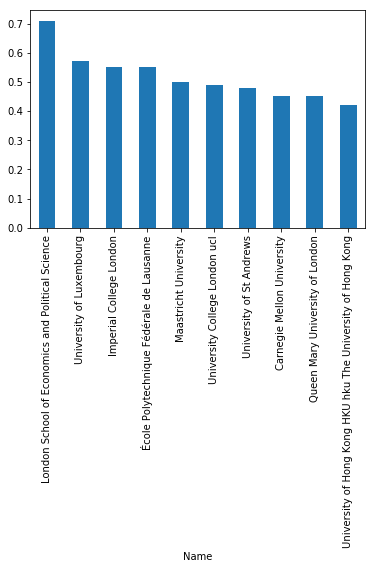

In [72]:
# We can see that results are involving almost the same university as the previous ranking.

international_ratio_times.plot(kind='bar')

In [73]:
by_country = universities_times.groupby(['Country']).sum()

faculty_by_country = best_faculty_ratio(by_country)
international_by_country = best_international_ratio(by_country)

print(faculty_by_country)
print(international_by_country)

Country
Denmark               0.165278
Russian Federation    0.136954
Japan                 0.133331
Italy                 0.130290
Switzerland           0.093165
United States         0.089308
Taiwan                0.086939
South Africa          0.085439
China                 0.084234
France                0.074815
dtype: float64
Country
Luxembourg        0.569934
United Kingdom    0.357189
Hong Kong         0.323925
Australia         0.311979
Singapore         0.304522
Switzerland       0.303592
New Zealand       0.289970
Ireland           0.269976
Austria           0.259986
Canada            0.224145
dtype: float64


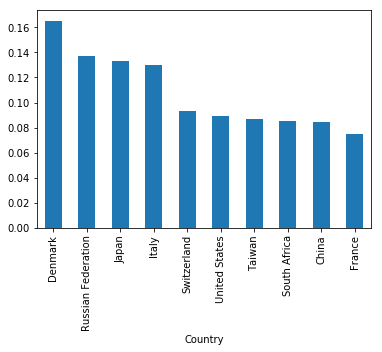

In [74]:
faculty_by_country.plot(kind='bar')

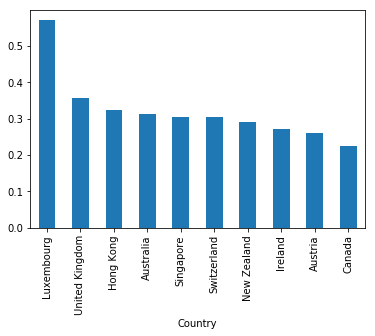

In [75]:
# Luxembourg has the higher international ratio, which makes sense as its population is very low.
# https://en.wikipedia.org/wiki/List_of_countries_by_population_(United_Nations)

international_by_country.plot(kind='bar')

We don't have information about university's region (we will get it back when merging the dataframes).

### Question 3

#### Method
To merge the two rankings, we have based our match with the following criterias : 
- University name : Used the Jaro–Winkler distance metrics to compare two university name
- Country name : Just compare the equality
- Students number : Computed the relative difference between the two rankings and allow maximum 20% difference. We first used also the total faculty member and International Student, but there was too many difference between the ranking. Only the Total Students is reliable.


In [76]:
from difflib import SequenceMatcher


def get_string_similarity_ratio(string1, string2):
    return SequenceMatcher(None, string1, string2).ratio()

# Return the most similar string 
def get_closest_match(x, list_strings):
    '''
    Can be used to get the closest match between a string x and a list of strings.
    '''
    best_match = None
    highest_jw = 0

    for current_string in list_strings:
        current_score = get_string_similarity_ratio(x, current_string)

        if(current_score > highest_jw):
            highest_jw = current_score
            best_match = current_string
            
        # If the string1 is contained in string2 or vice-versa we return
        if current_string in x or x in current_string:
            return current_string

    if highest_jw < 0.5: # If score is less than 20%, we refuse the result and skip the university
        return None

    return best_match

# Find the same University as the parameter in universities_top
def find_match(university):
    
    # Eliminate duplicate word
    words = university.split()
    university_no_duplicate = " ".join(sorted(set(words), key=words.index))
    
    match = get_closest_match(university_no_duplicate, universities_top.dropna().index)
    
    # If we do not found similar university name
    if match is None:
        return university
    
    # If the university is in the times university
    if match in universities_times.index:
        return university
    
    # If the country is not equal
    if universities_times.loc[university].Country != universities_top.loc[match].Country:
        return university
    
    # If the relative difference in term of students number is more than 20%
    # We choose to not include The total faculty members because there is too much difference between the two rankings
    columns_to_compare = ['Total Students']
    for column_name in columns_to_compare:
        students_times = universities_times.loc[university][column_name]
        students_top = universities_top.loc[match][column_name]
        difference_ratio = abs(students_times - students_top) / ((students_times + students_top) / 2)
        if difference_ratio > 0.20:
            return university
                
    return match

In [77]:
universities_times_index_renamed = universities_times.copy()
# Renaming times names based on top by getting the closest matches between the two names
universities_times_index_renamed.index = universities_times.index.map(find_match) 

universities = pd.DataFrame()
for name_times, university_times in universities_times_index_renamed.iterrows():
    if name_times in universities_top.index.tolist(): # Adding universities only in both rankings
        university_top = universities_top.loc[name_times]
        row = pd.DataFrame({
            'Name': [name_times],
            'Rank Top': university_top.Rank,
            'Rank Times': university_times.Rank,
            'Country': [university_top.Country],
            'Region': [university_top.Region],
            'Top Total Faculty Members': [int(university_top['Total Faculty Members'])],
            'Top International Faculty Members': [int(university_top['International Faculty Members'])],
            'Top Total Students': [int(university_top['Total Students'])],
            'Top International Students': [int(university_top['International Students'])],
            'Times Total Students': [university_times['Total Students']],
            'Times International Students': [university_times['International Students']],
            'Times Total Faculty Members': [university_times['Total Faculty Members']],
            })
        universities = universities.append(row)

universities = universities.set_index(['Name'])
    
print(universities[universities.index.duplicated()].index)
assert universities.index.is_unique, 'Index should be unique'


print(str(len(universities)) + ' universities after merge.')

universities.head()

Index([], dtype='object', name='Name')
150 universities after merge.


,Country,Rank Times,Rank Top,Region,Times International Students,Times Total Faculty Members,Times Total Students,Top International Faculty Members,Top International Students,Top Total Faculty Members,Top Total Students
Name,,,,,,,,,,,
University of Oxford,United Kingdom,1,6,Europe,7755,1822,20409,2964,7353,6750,19720
University of Cambridge,United Kingdom,2,5,Europe,6436,1687,18389,2278,6699,5490,18770
California Institute of Technology (Caltech),United States,3,4,North America,596,339,2209,350,647,953,2255
Stanford University,United States,3,2,North America,3485,2112,15845,2042,3611,4285,15878
Massachusetts Institute of Technology (MIT),United States,5,1,North America,3800,1284,11177,1679,3717,2982,11067


#### Other method : Use top website search function (javascript)
In the top university website https://www.topuniversities.com/university-rankings/world-university-rankings/2018 there is a search function. We used this latter to find the match between the top and times ranking. The javascript iterates over all the times universities, and search using its name to find the matching top university.

```javascript

var univs = [
"University of Oxford",
"California Institute of Technology caltech",
"Massachusetts Institute of Technology",
 ... 
]

let csv = ''
univs.forEach(function(univ, i) {
jQuery('input[placeholder="University search"]').val(univ).trigger('keyup')
csv += '"' + univ + '"' + ','+ '"'
  if (jQuery('table#qs-rankings tbody tr:first-child td:nth-child(1)').text() != "Oops... We couldn't find that university - please try searching again!") {
    csv += jQuery('table#qs-rankings tbody tr:first-child td:nth-child(2)').text()
  } else {
    csv += 'NaN'
  }

  csv += '"\n'
})
```

We end up with the following data :

In [78]:
matches_df = pd.read_csv('match_universities_from_js.csv')
matches_df = matches_df.dropna()
print(str(len(matches_df)) + ' universities merged using the top search function')

matches_df.head()

144 universities merged using the top search function


,Times University,Top University
0,University of Oxford,University of Oxford
1,California Institute of Technology caltech,California Institute of Technology (Caltech)
2,Massachusetts Institute of Technology,Massachusetts Institute of Technology (MIT)
3,Princeton University,Princeton University
4,University of Chicago,University of Chicago


#### Differences between the two methods

In [79]:
# Print the difference between the our find_match function result and the matches_df dataframe
# The criteria responsible for the non match is printed in red
def print_diff(matches_df):
    count = 0
    string_unmatch = 0
    student_unmatch = 0
    for index, university_pair in matches_df.iterrows():

        times = university_pair['Times University']
        top = university_pair['Top University']

        if times not in universities_times.index or top not in universities_top.dropna().index:
            continue

        if find_match(times) != top:
            count += 1
            print(times, "=matched=>",find_match(times) ,"!==" ,top)

            match = get_closest_match(times, universities_top.dropna().index)
                
            if match is not None:
                if match != top:
                    match = "\x1b[31m" + match + "\x1b[0m"
                    string_unmatch += 1
                print('String Similarity|', 'Closest:', match, 'Times/Closest:', get_string_similarity_ratio(times, match), 'Times/Top:', get_string_similarity_ratio(times, top))
            else:
                print('String Similarity| \x1b[31m\Match is None\"\x1b[0m')

            students_times = universities_times.loc[times]['Total Students']
            students_top = universities_top.loc[top]['Total Students']
            
            
            difference_ratio = abs(students_times - students_top) / ((students_times + students_top) / 2)
            if difference_ratio > 0.10:
                difference_ratio = "\x1b[31m" + str(difference_ratio) + "\x1b[0m"
                student_unmatch += 1
            print('Students|', 'Times:', students_times, 'Top:', students_top, 'RelativeDiff:', difference_ratio)

            print('\n')


    print('Number of difference :', count)
    print('String criteria unmatch :', string_unmatch)
    print('Students criteria unmatch :', student_unmatch)

print_diff(matches_df)

Ohio State University =matched=> Ohio State University !== The Ohio State University
String Similarity| Closest: The Ohio State University Times/Closest: 0.9130434782608695 Times/Top: 0.9130434782608695
Students| Times: 53190 Top: 43156.0 RelativeDiff: 0.208290951363


University of Sydney =matched=> The University of Sydney !== The University of New South Wales (UNSW Sydney)
String Similarity| Closest: The University of Sydney Times/Closest: 0.7547169811320755 Times/Top: 0.5970149253731343
Students| Times: 44553 Top: 39784.0 RelativeDiff: 0.113093897103


Number of difference : 2
String criteria unmatch : 1
Students criteria unmatch : 2


We observe that we got only 2 differences between our merge function and the top website search function. The problem can come from the high difference between students number (>10%) or the match using the string distance.

#### Difference between the right match
We manually matched the last universities.

In [80]:
true_matches_df = pd.read_csv('universities.csv', delimiter=';')
true_matches_df = true_matches_df.dropna()
print(str(len(true_matches_df)) + ' universities')

true_matches_df.head()

200 universities


,Times University,Top University
0,University of Oxford,University of Oxford
1,California Institute of Technology caltech,California Institute of Technology (Caltech)
2,Massachusetts Institute of Technology,Massachusetts Institute of Technology (MIT)
3,Princeton University,Princeton University
4,University of Chicago,University of Chicago


In [81]:
print_diff(true_matches_df)

Heidelberg University =matched=> Heidelberg University !== Ruprecht-Karls-Universität Heidelberg
String Similarity| Closest: Leiden University Times/Closest: 0.6382978723404256 Times/Top: 0.3448275862068966
Students| Times: 28876 Top: 28852.0 RelativeDiff: 0.000831485587583


University of North Carolina at Chapel Hill =matched=> University of North Carolina at Chapel Hill !== University of North Carolina, Chapel Hill
String Similarity| Closest: University of North Carolina, Chapel Hill Times/Closest: 0.9523809523809523 Times/Top: 0.9523809523809523
Students| Times: 34684 Top: 25373.0 RelativeDiff: 0.310072098173


Ohio State University =matched=> Ohio State University !== The Ohio State University
String Similarity| Closest: The Ohio State University Times/Closest: 0.9130434782608695 Times/Top: 0.9130434782608695
Students| Times: 53190 Top: 43156.0 RelativeDiff: 0.208290951363


Technical University of Berlin =matched=> Technical University of Berlin !== Technische Universität Berlin 

Our string matcher is responsible of the most of the differences.

### Question 4

#### 1. Making sense of data and cleaning statistically

##### 1.1 Pearson Vs. Spearman

Usually, when dealing with ordinal values such as rank, then it's recommended to use *Spearman correlation* coefficient between ordinal and ordinal values and between ordinal and continuous values. 

Similarly, for correlation between continuous values, *Pearson correlation* is the recommended method. But, here we observe that the difference in values for the two cases is less than **20%**, So, we will use **Spearman correlation** throughout in sake of simplicity 

In [82]:
abs(universities.corr(method='pearson') - universities.corr(method='spearman')) # max is < 0.2

,Rank Times,Rank Top,Times International Students,Times Total Faculty Members,Times Total Students,Top International Faculty Members,Top International Students,Top Total Faculty Members,Top Total Students
Rank Times,0.000000,0.039409,0.013403,0.034337,0.042697,0.030765,0.006946,0.014809,0.033063
Rank Top,0.039409,0.000000,0.027422,0.011037,0.021542,0.016772,0.010715,0.001511,0.018868
Times International Students,0.013403,0.027422,0.000000,0.061314,0.022240,0.000877,0.031723,0.003256,0.022010
Times Total Faculty Members,0.034337,0.011037,0.061314,0.000000,0.071783,0.010289,0.092053,0.031621,0.078216
Times Total Students,0.042697,0.021542,0.022240,0.071783,0.000000,0.026011,0.023056,0.039447,0.004446
Top International Faculty Members,0.030765,0.016772,0.000877,0.010289,0.026011,0.000000,0.020392,0.087520,0.028969
Top International Students,0.006946,0.010715,0.031723,0.092053,0.023056,0.020392,0.000000,0.001417,0.038303
Top Total Faculty Members,0.014809,0.001511,0.003256,0.031621,0.039447,0.087520,0.001417,0.000000,0.057475
Top Total Students,0.033063,0.018868,0.022010,0.078216,0.004446,0.028969,0.038303,0.057475,0.000000


##### 1.2: Adding independent features for Correlation Analysis

We, add some derived features from the columns that are actually independent of some other features and hence more suitable for Correlation Analysis. 

In [83]:
universities['Top Local Students'] = universities['Top Total Students'] - universities['Top International Students']
universities['Top Local Faculty Members'] = universities['Top Total Faculty Members'] - universities['Top International Faculty Members']
universities['Times Local Students'] = universities['Times Total Students'] - universities['Times International Students']

In [84]:
universities.corr(method = "spearman")

,Rank Times,Rank Top,Times International Students,Times Total Faculty Members,Times Total Students,Top International Faculty Members,Top International Students,Top Total Faculty Members,Top Total Students,Top Local Students,Top Local Faculty Members,Times Local Students
Rank Times,1.000000,0.737899,-0.243594,-0.264362,-0.103100,-0.337294,-0.250236,-0.368696,-0.111537,-0.073527,-0.272366,-0.072160
Rank Top,0.737899,1.000000,-0.235043,-0.250278,0.020513,-0.489396,-0.227593,-0.356428,0.015350,0.073106,-0.172725,0.076529
Times International Students,-0.243594,-0.235043,1.000000,0.247500,0.553494,0.554286,0.957067,0.397663,0.564220,0.395312,0.219142,0.384245
Times Total Faculty Members,-0.264362,-0.250278,0.247500,1.000000,0.584215,0.273397,0.280523,0.769631,0.586615,0.598147,0.812147,0.593755
Times Total Students,-0.103100,0.020513,0.553494,0.584215,1.000000,0.236034,0.573722,0.629454,0.992590,0.970382,0.640016,0.975409
Top International Faculty Members,-0.337294,-0.489396,0.554286,0.273397,0.236034,1.000000,0.558752,0.554679,0.241954,0.135344,0.230552,0.139419
Top International Students,-0.250236,-0.227593,0.957067,0.280523,0.573722,0.558752,1.000000,0.415881,0.592873,0.414018,0.244653,0.415354
Top Total Faculty Members,-0.368696,-0.356428,0.397663,0.769631,0.629454,0.554679,0.415881,1.000000,0.637180,0.616970,0.910243,0.607239
Top Total Students,-0.111537,0.015350,0.564220,0.586615,0.992590,0.241954,0.592873,0.637180,1.000000,0.971945,0.644527,0.965111
Top Local Students,-0.073527,0.073106,0.395312,0.598147,0.970382,0.135344,0.414018,0.616970,0.971945,1.000000,0.674242,0.990560


##### 1.3: Making it mangaeable: Weighed Averaging of data using Corr

We're weighed averaging the data from 'Local Students'. 'Total International Students' and 'Total Faculty' in inverse ratio of their correlation to their own rankings.

In [85]:
universities['Local Students'] = (0.02*universities['Times Local Students'] + 0.15*universities['Top Local Students'])//0.17
del universities['Top Local Students']
del universities['Times Local Students']
universities['Total International Students'] = (0.26*universities['Times International Students'] + 0.42*universities['Top International Students'])//0.68
del universities['Times International Students']
del universities['Top International Students']
universities['Total Faculty'] = (0.31*universities['Times Total Faculty Members'] + 0.43*universities['Top Total Faculty Members'])//0.74
del universities['Times Total Faculty Members']
del universities['Top Total Faculty Members']

And Removing the spurious Total Students data 

In [86]:
universities['Total Students'] = universities['Local Students'] +  universities['Total International Students']
del universities['Times Total Students']
del universities['Top Total Students']

Reassigning Local Members from new data

In [87]:
universities['Local Faculty'] = universities['Total Faculty'] - universities['Top International Faculty Members']
universities['International Faculty'] = universities['Top International Faculty Members']
del universities['Top International Faculty Members']
del universities['Top Local Faculty Members']

##### 1.4 More Derived ratios: Regaining the lost dimensions

Adding in Student Faculty Ratio and Local to International Faculy and student ratio

In [88]:
universities['Student Faculty Ratio'] =  universities['Total Students']/universities['Total Faculty']
universities['I2L Students'] = universities['Total International Students']/universities['Local Students']
universities['I2L Faculty'] = universities['International Faculty']/universities['Local Faculty']
universities['I2I Student Faculty Ratio'] =  universities['Total International Students']/universities['International Faculty']

#### 2. Looking closely at correlations.

In [89]:
abs(universities.corr(method = "spearman"))

,Rank Times,Rank Top,Local Students,Total International Students,Total Faculty,Total Students,Local Faculty,International Faculty,Student Faculty Ratio,I2L Students,I2L Faculty,I2I Student Faculty Ratio
Rank Times,1.000000,0.737899,0.071173,0.240834,0.370765,0.110604,0.202219,0.337294,0.251898,0.181342,0.093912,0.139757
Rank Top,0.737899,1.000000,0.075004,0.225923,0.356598,0.015294,0.082948,0.489396,0.421432,0.317283,0.307574,0.344783
Local Students,0.071173,0.075004,1.000000,0.408493,0.638055,0.974286,0.668090,0.135698,0.452495,0.446749,0.367855,0.286578
Total International Students,0.240834,0.225923,0.408493,1.000000,0.373399,0.579383,0.118370,0.561357,0.314060,0.570543,0.335359,0.376572
Total Faculty,0.370765,0.356598,0.638055,0.373399,1.000000,0.648881,0.851065,0.470074,0.290748,0.174840,0.230916,0.095494
Total Students,0.110604,0.015294,0.974286,0.579383,0.648881,1.000000,0.614145,0.240303,0.463088,0.267824,0.251889,0.338351
Local Faculty,0.202219,0.082948,0.668090,0.118370,0.851065,0.614145,1.000000,0.032608,0.183644,0.452985,0.637360,0.124562
International Faculty,0.337294,0.489396,0.135698,0.561357,0.470074,0.240303,0.032608,1.000000,0.199372,0.460076,0.679706,0.458524
Student Faculty Ratio,0.251898,0.421432,0.452495,0.314060,0.290748,0.463088,0.183644,0.199372,1.000000,0.079703,0.006263,0.550188
I2L Students,0.181342,0.317283,0.446749,0.570543,0.174840,0.267824,0.452985,0.460076,0.079703,1.000000,0.704012,0.080400


#### Result A: Concluding the ranking factors

It is very interesting to conclude the basis of rankings for Times and Top University Rankings from the data! Observe that 
the correlations for Times rankings are higher for some features while much lower for others. Specifically, we conclude,

##### Times Rankings: Both Students and Faculty

Times rankings correlate better with Local students and International Students considerably better than Top University rankings. And both correlate with Total and International Faculty. So, Times rankings has a wider criterion for rankings.        

##### Top Universities Rankings: More faculty and research based

Top University rankings correlate extremely weakly with students but more strongly with the faculty numbers sugeesting it's more research faculty oriented than times.

#### Result B: The curious case of Local Students

Observe that both times and university rankings are better correlated with *International Students* compared to *Local Students*. This is either an artifact of the fact that, <u>good universities attract more international students</u> or the other way around - *International Students make a university better*. Of course, we cannot conclude causation either way from the above data

#### Result C: How Subjective being Good is?

We look at strongly do the two different rankings agree on what places are good and what are not so good? 

In [90]:
print('How often do the rankings agree relatively between universities top 50? ->',
      universities[universities['Rank Times'] < 50].corr(method = "spearman")['Rank Times']['Rank Top'])    

How often do the rankings agree relatively between universities top 50? -> 0.757495374668


In [91]:
print('How often do the rankings agree relatively between universities in beween 50 to 100? ->',
      universities[np.logical_and(universities['Rank Times'] < 100 , universities['Rank Times'] > 50)].corr(method = "spearman")['Rank Times']['Rank Top'])   

How often do the rankings agree relatively between universities in beween 50 to 100? -> 0.214664991462


In [92]:
print('How often do the rankings agree relatively between universities in beween 100 to 200? ->',
      universities[np.logical_and(universities['Rank Times'] < 200 , universities['Rank Times'] > 100)].corr(method = "spearman")['Rank Times']['Rank Top'])

How often do the rankings agree relatively between universities in beween 100 to 200? -> 0.138623915383


So, we conclude that while Both rankings agree between themselves in comparaison trends for the top 50 universities very tightly. 
This, agreement loses sharply for the next 50 and even more for the next 100 compared to the top 100. In conclusion, **while, both agree on the Good ones, the bad ones are subjective to each**.

#### 3. Merging rankings

This is highly subjective. There are a number of methods to merge. We are presenting the final method as an ensemble of two reasonalbe methods.

In [93]:
to_remove = ['Country', 'Region', 'Local Students', 'Local Faculty', 'International Faculty', 'Student Faculty Ratio','I2L Students', 'I2L Faculty', 'I2I Student Faculty Ratio']
for entry in to_remove:
    del universities[entry]

##### Method 1: Ranking the Average ranks

As a simple method, we use calculate the average rank from the two ranks asigned and then, re-rank on the basis of this calculate average.

In [94]:
universities['Average Rank'] = ((universities['Rank Times'] + universities['Rank Top'])/2).rank(method = "first", ascending = 1)
universities.sort_values('Average Rank' , inplace = True)
universities.head()

,Rank Times,Rank Top,Total International Students,Total Faculty,Total Students,Average Rank
Name,,,,,,
Stanford University,3,2,3562.0,3374.0,15839.0,1.0
Massachusetts Institute of Technology (MIT),5,1,3748.0,2270.0,11101.0,2.0
University of Oxford,1,6,7506.0,4685.0,19906.0,3.0
University of Cambridge,2,5,6598.0,3896.0,18655.0,4.0
California Institute of Technology (Caltech),3,4,627.0,695.0,2235.0,5.0


## Method 2 : Merging with weighed averaged ranks

For the second method, we plan to merge the rankings **completely independent of the ranks assigned by Times and Topuniversities rankings.**

We consider three factors common to both rankings - International Student, Total Faculty Members and Total Students. For, each of these factors, we rank all the universities on the basis of the factor (independent of other factors) and store these ranks 

In [95]:
del universities['Rank Top']
del universities['Rank Times']

**The columns marked IR have the inverted ranks for each factor or each university.**

In [96]:
columns_considered_for_ranking = ['Total International Students','Total Faculty','Total Students']
for column in columns_considered_for_ranking:
    universities.sort_values(column , inplace = True)
    universities['IR'+column] = range(1,universities.shape[0]+1)
universities.head()

,Total International Students,Total Faculty,Total Students,Average Rank,IRTotal International Students,IRTotal Faculty,IRTotal Students
Name,,,,,,,
Scuola Normale Superiore di Pisa,43.0,91.0,526.0,150.0,1,1,1
École Normale Supérieure de Lyon,246.0,331.0,2060.0,144.0,3,2,2
California Institute of Technology (Caltech),627.0,695.0,2235.0,5.0,5,6,3
Pohang University of Science And Technology (POSTECH),124.0,508.0,3107.0,88.0,2,3,4
Ecole Polytechnique,955.0,606.0,3108.0,71.0,8,4,5


Now, we merge these inverted ranks by making an index WR that is the weighed sum of these ranks, weighed by the 
sum of the correlations between the factor and the two rankings. So, if, a university has rank 42 by Total International Students,
and the correlation of Total Internation Students with Times and Top is (say) 0.2 and 0.6, it contributes a value of 
0.8*42 to the WE index. 

Then, after accouting for all factors, we rank the universities on basis of this WR ranking. 

In [97]:
times_corr = universities_times.corr(method = "spearman")
top_corr = universities_top.corr(method = "spearman")
universities['WR'] = [0]*universities.shape[0]

In [98]:
times_corr

,International Students,Rank,Total Faculty Members,Total Students
International Students,1.000000,-0.322767,0.337869,0.582845
Rank,-0.322767,1.000000,-0.283557,-0.152917
Total Faculty Members,0.337869,-0.283557,1.000000,0.589501
Total Students,0.582845,-0.152917,0.589501,1.000000


In [99]:
TIS_weight = abs(times_corr['Rank']['International Students'] + top_corr['Rank']['International Students'])
TF_weight = abs(times_corr['Rank']['Total Faculty Members'] + top_corr['Rank']['Total Faculty Members'])
TS_weight = abs(times_corr['Rank']['Total Students'] + top_corr['Rank']['Total Students'] )
weight = [TIS_weight,TF_weight,TS_weight]

In [100]:
for i,column in enumerate(columns_considered_for_ranking):
    universities['WR'] += universities['IR'+column]*weight[i] 
    del universities['IR'+column]
universities.sort_values('WR' , ascending = False , inplace = True)
universities['Weighed Rank'] = range(1,universities.shape[0]+1)
del universities['WR']

In [101]:
universities

,Total International Students,Total Faculty,Total Students,Average Rank,Weighed Rank
Name,,,,,
University of Toronto,18045.0,7122.0,69204.0,25.0,1
UCL (University College London),14851.0,4895.0,30986.0,11.0,2
University of British Columbia,12787.0,3901.0,51499.0,39.0,3
The University of Manchester,13478.0,3866.0,36485.0,41.0,4
University of Michigan,7206.0,5993.0,42768.0,19.0,5
National University of Singapore (NUS),9017.0,3721.0,32546.0,17.0,6
Columbia University,8258.0,5421.0,25332.0,15.0,7
Peking University,6956.0,4996.0,42043.0,30.0,8
The Ohio State University,7476.0,4361.0,43727.0,91.0,9


#### Final Rank : An average of both ranks

We average both re-rank on the basis of this index. 

In [102]:
universities['Final Rank'] = ((universities['Weighed Rank'] + universities['Average Rank'])/2).rank(method = "first", ascending = 1)
universities.sort_values('Final Rank' , inplace = True)
universities.head()

,Total International Students,Total Faculty,Total Students,Average Rank,Weighed Rank,Final Rank
Name,,,,,,
UCL (University College London),14851.0,4895.0,30986.0,11.0,2,1.0
Columbia University,8258.0,5421.0,25332.0,15.0,7,2.0
National University of Singapore (NUS),9017.0,3721.0,32546.0,17.0,6,3.0
University of Oxford,7506.0,4685.0,19906.0,3.0,20,4.0
University of Michigan,7206.0,5993.0,42768.0,19.0,5,5.0


In [103]:
universities

,Total International Students,Total Faculty,Total Students,Average Rank,Weighed Rank,Final Rank
Name,,,,,,
UCL (University College London),14851.0,4895.0,30986.0,11.0,2,1.0
Columbia University,8258.0,5421.0,25332.0,15.0,7,2.0
National University of Singapore (NUS),9017.0,3721.0,32546.0,17.0,6,3.0
University of Oxford,7506.0,4685.0,19906.0,3.0,20,4.0
University of Michigan,7206.0,5993.0,42768.0,19.0,5,5.0
University of Toronto,18045.0,7122.0,69204.0,25.0,1,6.0
The University of Edinburgh,10609.0,3264.0,27929.0,23.0,11,7.0
Peking University,6956.0,4996.0,42043.0,30.0,8,8.0
University of British Columbia,12787.0,3901.0,51499.0,39.0,3,9.0


## Justification for all the circus:

<li> We were asked to calculate a merged rank on the basis f the data website provide us. It is obvious that the websites would themselved use much more factors than just 3-4 to weight and rank universities. However, we are supposed to use THESE factors and not the ones the've used originally.
<li> The Weighed Rank is an estimate on the basis of these 3 factors : Total International Students , Total Faculty and Total Students not using the ranks the university themselves assigned the ranks using only the correlation between rank and factors.
<li> However, to use also the other *hidden* factors we make an Average rank index 
<li> Thus, the final rank is a contribution of both ranks equally, taking into mind the factors that we are supposed to emphasize and other factors hidden to us.